In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)

In [2]:
df1=pd.read_csv("clean_data.csv")
df1.head()

,price,area,status,bhk,bathroom,age,location,builder
0,37.49,872,Ready to move,2,NaN,1.0,Sembakkam,MP Developers
1,93.54,1346,Under Construction,3,2.0,NaN,Selaiyur,DAC Promoters
2,151.00,2225,Under Construction,3,NaN,0.0,Mogappair,Casagrand Builder Private Limited
3,49.00,1028,Ready to move,2,2.0,3.0,Ambattur,Dugar Housing Builders
4,42.28,588,Under Construction,2,1.0,0.0,Pallavaram,Radiance Realty Developers India Ltd


In [3]:
df1.shape

(2620, 8)

In [4]:
df2=df1.drop(['status','age','builder'],axis='columns')
df2.head()

,price,area,bhk,bathroom,location
0,37.49,872,2,NaN,Sembakkam
1,93.54,1346,3,2.0,Selaiyur
2,151.00,2225,3,NaN,Mogappair
3,49.00,1028,2,2.0,Ambattur
4,42.28,588,2,1.0,Pallavaram


In [5]:
df2.isnull().sum()

price          0
area           0
bhk            0
bathroom    1217
location       0
dtype: int64

In [6]:
df2['bathroom'].median()

2.0

In [7]:
#filling the nan values with median
df3=df2.fillna(df2['bathroom'].median())
df3.head()

,price,area,bhk,bathroom,location
0,37.49,872,2,2.0,Sembakkam
1,93.54,1346,3,2.0,Selaiyur
2,151.00,2225,3,2.0,Mogappair
3,49.00,1028,2,2.0,Ambattur
4,42.28,588,2,1.0,Pallavaram


In [8]:
df3['bhk'].unique()

array([2, 3, 4, 1, 5, 6, 8], dtype=int64)

In [9]:
df3['area'].unique()

array([ 872, 1346, 2225, ..., 1127, 1131,  898], dtype=int64)

In [10]:
df3['price'].unique()

array([ 37.49,  93.54, 151.  , ...,  23.94, 340.  ,  31.5 ])

In [11]:
#price in lakhs
df4=df3.copy()
df4['price_per_sqft']=df4['price']*100000/df4['area']
df4.head()

,price,area,bhk,bathroom,location,price_per_sqft
0,37.49,872,2,2.0,Sembakkam,4299.311927
1,93.54,1346,3,2.0,Selaiyur,6949.479941
2,151.00,2225,3,2.0,Mogappair,6786.516854
3,49.00,1028,2,2.0,Ambattur,4766.536965
4,42.28,588,2,1.0,Pallavaram,7190.476190


In [12]:
#no. of different locations
len(df4['location'].unique())

178

In [13]:
df4.location=df4.location.apply(lambda x: x.strip())
location_stats =df4.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Veppampattu                       149
Pammal                            139
Medavakkam                        111
Sholinganallur                     99
Perungudi                          88
                                 ... 
Red Hills                           1
Padapai                             1
Oragadam Village Ambattur Talu      1
Thiruvidandhai                      1
Padi                                1
Name: location, Length: 178, dtype: int64

In [14]:
len(location_stats[location_stats<=10])

119

In [15]:
location_stats_less_than_10=location_stats[location_stats<=10]
location_stats_less_than_10

location
Urapakkam                         10
Thandalam                         10
Ambattur INDUSTRIAL ESTATE        10
Kilpauk                            9
Saidapet                           9
                                  ..
Red Hills                          1
Padapai                            1
Oragadam Village Ambattur Talu     1
Thiruvidandhai                     1
Padi                               1
Name: location, Length: 119, dtype: int64

In [16]:
df4.location=df4.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df4.location.unique())

60

In [17]:
df4.head()

,price,area,bhk,bathroom,location,price_per_sqft
0,37.49,872,2,2.0,Sembakkam,4299.311927
1,93.54,1346,3,2.0,Selaiyur,6949.479941
2,151.00,2225,3,2.0,Mogappair,6786.516854
3,49.00,1028,2,2.0,Ambattur,4766.536965
4,42.28,588,2,1.0,Pallavaram,7190.476190


### Outlier Detection

In [18]:
#setting threshold for sqt
df4[df4.area/df4.bhk<300].head()

,price,area,bhk,bathroom,location,price_per_sqft
4,42.28,588,2,1.0,Pallavaram,7190.476190
6,38.00,885,3,2.0,Thirumazhisai,4293.785311
43,42.28,588,2,1.0,Pallavaram,7190.476190
54,29.62,528,2,2.0,Pammal,5609.848485
206,35.34,594,2,2.0,Vengaivasal,5949.494949


In [19]:
df4.shape

(2620, 6)

In [20]:
#removing outliers
df5=df4[~(df4.area/df4.bhk<300)]
df5.shape

(2593, 6)

In [21]:
#min and max are rare cases
df5.price_per_sqft.describe()

count     2593.000000
mean      6396.745568
std       3422.929203
min       1743.119266
25%       4606.060606
50%       5417.177914
75%       6640.625000
max      26086.956522
Name: price_per_sqft, dtype: float64

In [22]:
#filtering beyond standard deviation 1
def remove_pps_outliers(df):
    df_out=pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_sqft)
        st=np.std(subdf.price_per_sqft)
        reduced_df=subdf[(subdf.price_per_sqft>(m-st))&(subdf.price_per_sqft<=(m+st))]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df6= remove_pps_outliers(df5)
df6.shape
        


(2011, 6)

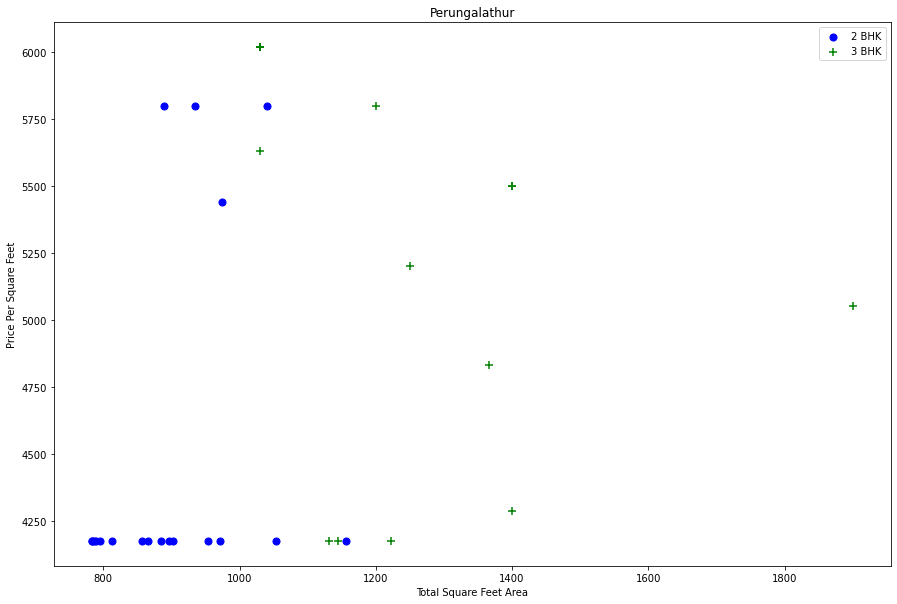

In [23]:
#scatter to visualise same area with different prize
def plot_scatter_chart(df,location):
    bhk2=df[(df.location==location)&(df.bhk==2)]
    bhk3=df[(df.location==location)&(df.bhk==3)]
    matplotlib.rcParams['figure.figsize']=(15,10)
    plt.scatter(bhk2.area,bhk2.price_per_sqft,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.area,bhk3.price_per_sqft,marker='+',color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price Per Square Feet")
    plt.title(location)
    plt.legend()
plot_scatter_chart(df6,"Perungalathur")

In [24]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats={}
        for bhk, bhk_df in df.groupby('bhk'):
            bhk_stats[bhk]={
                'mean':np.mean(bhk_df.price_per_sqft),
                'std':np.std(bhk_df.price_per_sqft),
                'count':bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats=bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices=np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')   
df7=remove_bhk_outliers(df6)
df7.shape

(1337, 6)

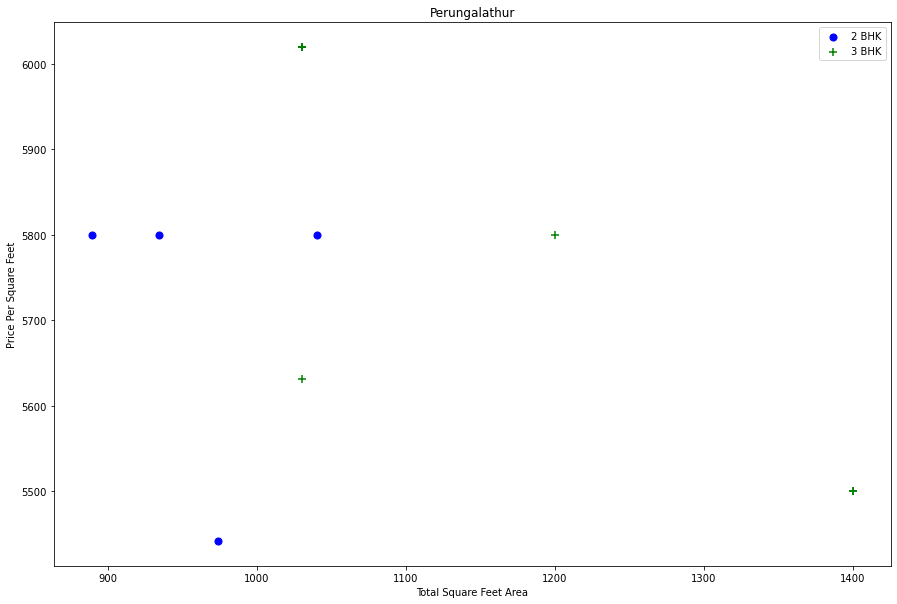

In [25]:
plot_scatter_chart(df7,"Perungalathur")

Text(0, 0.5, 'count')

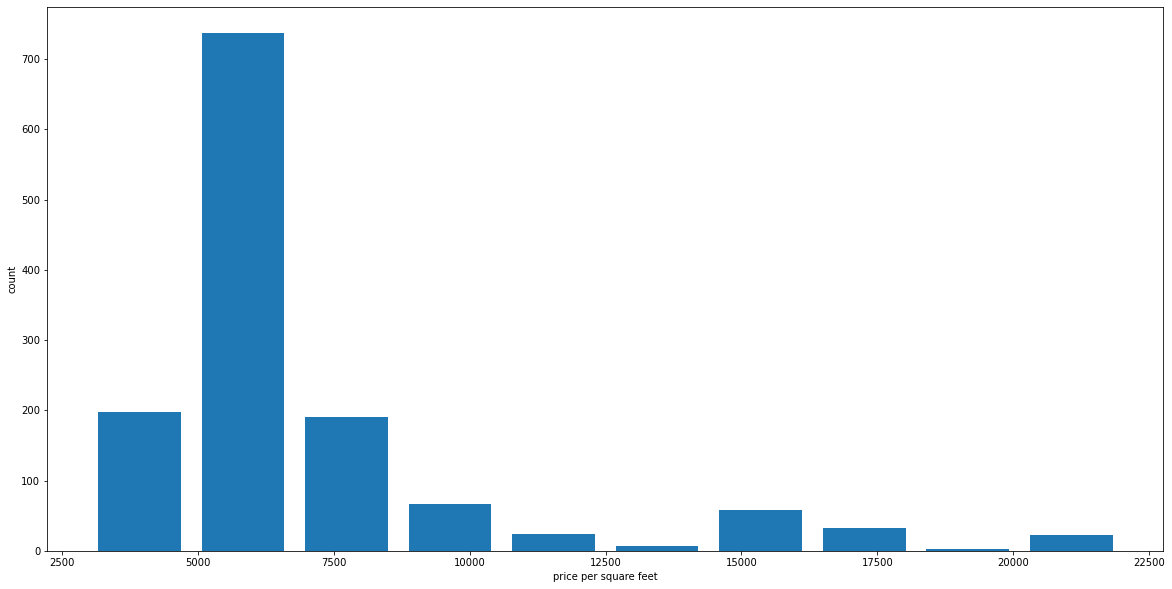

In [26]:
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
plt.hist(df7.price_per_sqft,rwidth=0.8)
plt.xlabel("price per square feet")
plt.ylabel("count")

In [27]:
df7.bathroom.unique()

array([2., 3., 4., 1., 5.])

In [28]:
#processing text data
df8=df7.drop(['price_per_sqft'],axis='columns')
df8.head()

,price,area,bhk,bathroom,location
0,261.0,1548,3,2.0,Adyar
1,278.0,1652,3,2.0,Adyar
2,274.0,1627,3,2.0,Adyar
3,210.0,1381,3,3.0,Adyar
4,325.0,2411,4,4.0,Adyar


In [29]:
dummies=pd.get_dummies(df8.location)
dummies.head()

,Adyar,Alwarpet,Ambattur,Anna Nagar,Ayanambakkam,Chromepet,East Tambaram,Gerugambakkam,Gowrivakkam,Guduvancheri,...,Tiruvottiyur,Vadanemmeli,Vadapalani,Vanagaram,Velachery,Vengaivasal,Veppampattu,West Mambalam,other,tambaram west
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df9=pd.concat([df8,dummies.drop('other',axis='columns')],axis='columns')
df9.head()

,price,area,bhk,bathroom,location,Adyar,Alwarpet,Ambattur,Anna Nagar,Ayanambakkam,...,Thirumazhisai,Tiruvottiyur,Vadanemmeli,Vadapalani,Vanagaram,Velachery,Vengaivasal,Veppampattu,West Mambalam,tambaram west
0,261.0,1548,3,2.0,Adyar,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,278.0,1652,3,2.0,Adyar,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,274.0,1627,3,2.0,Adyar,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,210.0,1381,3,3.0,Adyar,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,325.0,2411,4,4.0,Adyar,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
#drop location column
df10=df9.drop('location',axis='columns')
df10.head()

,price,area,bhk,bathroom,Adyar,Alwarpet,Ambattur,Anna Nagar,Ayanambakkam,Chromepet,...,Thirumazhisai,Tiruvottiyur,Vadanemmeli,Vadapalani,Vanagaram,Velachery,Vengaivasal,Veppampattu,West Mambalam,tambaram west
0,261.0,1548,3,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,278.0,1652,3,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,274.0,1627,3,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,210.0,1381,3,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,325.0,2411,4,4.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df10.shape

(1337, 61)

In [33]:
X=df10.drop('price',axis='columns')
X.head()

,area,bhk,bathroom,Adyar,Alwarpet,Ambattur,Anna Nagar,Ayanambakkam,Chromepet,East Tambaram,...,Thirumazhisai,Tiruvottiyur,Vadanemmeli,Vadapalani,Vanagaram,Velachery,Vengaivasal,Veppampattu,West Mambalam,tambaram west
0,1548,3,2.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1652,3,2.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1627,3,2.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1381,3,3.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2411,4,4.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
Y=df10.price
Y.head()

0    261.0
1    278.0
2    274.0
3    210.0
4    325.0
Name: price, dtype: float64

In [35]:
#building model
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=10)

In [36]:
#linear regression model
from sklearn.linear_model import LinearRegression
lr_clf=LinearRegression()
lr_clf.fit(X_train,Y_train)
lr_clf.score(X_test,Y_test)

0.9495390349807835

In [37]:
#k-fold cross validaion
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
cross_val_score(LinearRegression(),X,Y,cv=cv)

array([0.9080994 , 0.94976754, 0.93279545, 0.95400859, 0.95522908])

In [38]:
#grid search cv(runs on diff regression and tells best model)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
def find_best_model_using_gridsearchcv(X,Y):
    algos={
        'linear_regression':{
            'model':LinearRegression(),
            'params':{
                'normalize':[True,False]
            }
    },
     'lasso':{
            'model':Lasso(),
            'params':{
                'alpha':[1,2],
                'selection':['random','cyclic']
            }
     },
        'decision_tree':{
            'model':DecisionTreeRegressor(),
            'params':{
                'criterion':['mse','friedman_mse'],
                'splitter':['best','random']
            } 
        }
     }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,Y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,Y)

            

,model,best_score,best_params
0,linear_regression,0.939980,{'normalize': False}
1,lasso,0.871981,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.962803,"{'criterion': 'mse', 'splitter': 'best'}"


In [39]:
X.columns

Index(['area', 'bhk', 'bathroom', 'Adyar', 'Alwarpet', 'Ambattur',
       'Anna Nagar', 'Ayanambakkam', 'Chromepet', 'East Tambaram',
       'Gerugambakkam', 'Gowrivakkam', 'Guduvancheri', 'Guindy',
       'Iyappanthangal', 'Iyyappanthangal', 'Karapakkam', 'Kelambakkam',
       'Kolapakkam', 'Kolathur', 'Kotturpuram', 'Kovur', 'Koyambedu',
       'Kundrathur', 'Madambakkam', 'Madhavaram', 'Madipakkam', 'Medavakkam',
       'Mogappair', 'Mugalivakkam', 'Nanmangalam', 'Navallur', 'Pallavaram',
       'Pammal', 'Perumbakkam', 'Perungalathur', 'Perungudi', 'Poonamallee',
       'Porur', 'Pozhichalur', 'Rajakilpakkam', 'Royapettah', 'Selaiyur',
       'Sembakkam', 'Semmancheri', 'Sholinganallur', 'Siruseri',
       'Sithalapakkam', 'T Nagar', 'Thaiyur', 'Thirumazhisai', 'Tiruvottiyur',
       'Vadanemmeli', 'Vadapalani', 'Vanagaram', 'Velachery', 'Vengaivasal',
       'Veppampattu', 'West Mambalam', 'tambaram west'],
      dtype='object')

In [40]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [41]:
predict_price('Chromepet',1000, 2, 2)

59.03244895714022

In [42]:
predict_price('Chromepet',1000, 3, 2)

48.699900187777544

In [43]:
predict_price('Selaiyur',1000, 2, 2)

53.48198084950039

In [44]:
predict_price('Selaiyur',1000, 3, 2)

43.149432080137714

In [46]:
import pickle
with open('home_price_prediction_model.pickle','wb') as hppm:
    pickle.dump(lr_clf,hppm)

In [47]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as hppm:
    hppm.write(json.dumps(columns))